# Twitter analysis of climate change perceptions

In [42]:
# Import libraries
import config
import pandas as pd
import numpy as np
import itertools
import collections
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)

# Text processing tools
import tweepy
from textblob import TextBlob
from textblob import Word
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Visualization libraries
from geopy.geocoders import Nominatim
import gmplot
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


sns.set(font_scale=1.5)
sns.set_style("whitegrid")

[nltk_data] Downloading package stopwords to /home/ivana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
# Interacting with twitter's API
auth = tweepy.OAuthHandler(config.consumer_key, config.consumer_secret) 
auth.set_access_token(config.access_token, config.access_token_secret)
api = tweepy.API (auth, wait_on_rate_limit = True) 

In [44]:
# Clean the tweets
def clean_tweet(tweet):
    """ Utility function to clean a tweet by removing 
    links and special characters using regex.

    Parameters
    ----------
    tweet : string
        A text string that you want to parse and remove special characters.

    Returns
    -------
    The same tweet string without special characters removed.
    """
    
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())   

In [56]:
# List of tweets related to climate change
search_words = ("#ClimateChange", "Environment", "climate", "climatechange", "environment")


def get_tweets_df(search_words):
    """Extracts tweets, finds sentiment score and returns tweets as a DataFrame 

    Parameters
    ----------
    search_words : list 
        A list of phrases to extract
    
    Returns
    -------
    Pandas DataFrame of tweets
    """
    res = []
    # Extract tweets for a given list of phrases
    for word in search_words:
        for tweet in tweepy.Cursor (api.search, 
                                    q = word + " -filter:retweets", 
                                    lang = "en").items(30):
            res.append(tweet)
   
    id_list = [tweet.id for tweet  in res]
    
    # Create tweets DataFrame
    data_set = pd.DataFrame(id_list, columns = ["id"])
    data_set["text"] = [tweet.text for tweet in res]
    data_set["len"]  = np.array([len(tweet.text) for tweet in res])
    data_set["created_at"] = [tweet.created_at for tweet in res]
    data_set["user_location"] = [tweet.author.location for tweet in res]
    data_set["Hashtags"] = [tweet.entities.get('hashtags') for tweet in res]
    
    # Use clean function to remove special characters
    data_set["text"] = np.array([ clean_tweet(tweet) for tweet in data_set['text'] ])
    
    # Add Sentiment score and class
    text = data_set["text"]
    for i in range(0,len(text)):
        textB = TextBlob(text[i])
        sentiment = textB.sentiment.polarity

        data_set.at[i, 'sentiment'] = sentiment
        if sentiment <0.00:
            SentimentClass = 'Negative'
            data_set.at[i, 'sentiment_class'] = SentimentClass 
        elif sentiment >0.00:
            SentimentClass = 'Positive'
            data_set.at[i, 'sentiment_class']= SentimentClass 
        else:
            SentimentClass = 'Neutral'
            data_set.at[i, 'sentiment_class']= SentimentClass
    
    return data_set
    

In [57]:
# Create tweets DataFrame
tweets_df = get_tweets_df(search_words)
tweets_df.head()

,id,text,len,created_at,user_location,Hashtags,sentiment,sentiment_class
0,1180077768131960838,I m crying ClimateChange ClimateAction ClimateCrisis,81,2019-10-04 11:10:39,Greater Toronto Area,"[{'text': 'ClimateChange', 'indices': [13, 27]}, {'text': 'ClimateAction', 'indices': [28, 42]}, {'text': 'ClimateCrisis', 'indices': [43, 57]}]",-0.200000,Negative
1,1180077650246803458,These houses cost an arm leg and lung Super campaign from BBDO airpollution climatechange,127,2019-10-04 11:10:11,London,"[{'text': 'airpollution', 'indices': [73, 86]}, {'text': 'climatechange', 'indices': [87, 101]}]",0.333333,Positive
2,1180077634371358720,AOC supporter We need to eat the babies Wow Bizarre people Sick socialism Watch the video,123,2019-10-04 11:10:07,"Trump Tower, USA",[],-0.071429,Negative
3,1180077592164126720,Dr Tony Knowles delivers the CH Special Report on climatechange desertification land degradation sustaina,140,2019-10-04 11:09:57,"Pretoria, South Africa","[{'text': 'climatechange', 'indices': [56, 70]}]",0.357143,Positive
4,1180077579409207296,73 percent of pension seek to influence ClimateChange ClimateAction,95,2019-10-04 11:09:54,London,"[{'text': 'pension', 'indices': [14, 22]}, {'text': 'ClimateChange', 'indices': [41, 55]}, {'text': 'ClimateAction', 'indices': [81, 95]}]",0.000000,Neutral


### Text clean up
To preprocess the tweets we will need to replace capital letters with lower case, remove stopwords and transform words to their base form.


In [58]:
# Create a list of lists containing lowercase words for each tweet
lower_tweets = [tweet.lower().split() for tweet in tweets_df.text] 
lower_tweets[:2]

[['i', 'm', 'crying', 'climatechange', 'climateaction', 'climatecrisis'],
 ['these',
  'houses',
  'cost',
  'an',
  'arm',
  'leg',
  'and',
  'lung',
  'super',
  'campaign',
  'from',
  'bbdo',
  'airpollution',
  'climatechange']]

In [59]:
# Remove stopwords
stop_words = set(stopwords.words('english'))
tweets_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in lower_tweets]
tweets_nsw[:2]

[['crying', 'climatechange', 'climateaction', 'climatecrisis'],
 ['houses',
  'cost',
  'arm',
  'leg',
  'lung',
  'super',
  'campaign',
  'bbdo',
  'airpollution',
  'climatechange']]

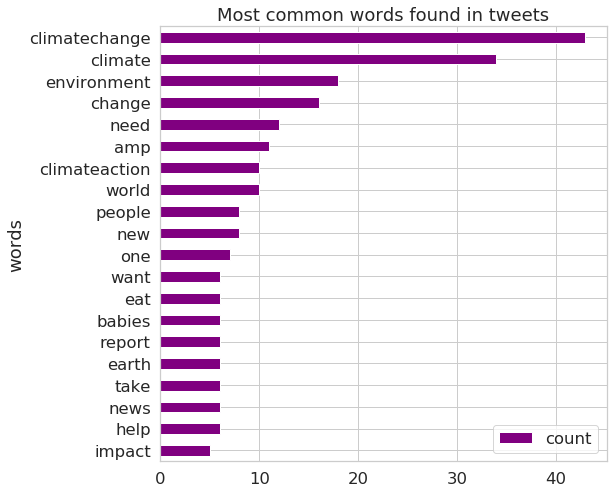

In [60]:
# Flatten list of words in clean tweets
all_words_nsw = list(itertools.chain(*tweets_nsw))

# Create a counter of top 20 terms
words_count = collections.Counter(all_words_nsw)
clean_tweets_nsw = pd.DataFrame(words_count.most_common(20), columns=['words', 'count'])

# Plot horizontal bar graph
fig, ax = plt.subplots(figsize=(8, 8))
clean_tweets_nsw.sort_values(by='count').plot.barh(x='words',
                                                  y='count',
                                                  ax=ax,
                                                  color='purple')
ax.set_title("Most common words found in tweets")
plt.show()

In addition to removal of stopwords, we will also create a collection of our own topic related words. Since we have  used "climated change" as a collection term, this term appear in every collected tweet. Therefore, we can expect that these terms will dominate the list of the most frequent words. In order to obtain new insight into the perceptions of twitter users we remove the search words from tweets through list comprehension.

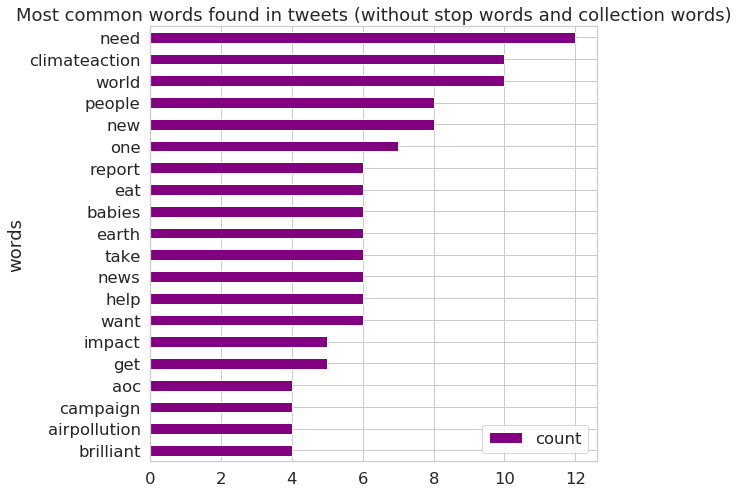

In [61]:
# Create a list of words to remove
remove_words = ("#ClimateChange", "Environment", "climate", "climatechange", "change", "amp", "much", "environment")

# Remove search words and rerun word frequency plot
tweets_nsw_rsw = [[w for w in word if not w in remove_words]
                  for word in tweets_nsw]

# Flatten list of words in clean tweets
all_words_nsw_rsw = list(itertools.chain(*tweets_nsw_rsw))

# Create a counter of top 20 terms
words_count = collections.Counter(all_words_nsw_rsw)
clean_tweets_nsw = pd.DataFrame(words_count.most_common(20), columns=['words', 'count'])

# Plot horizontal bar graph
fig, ax = plt.subplots(figsize=(8, 8))
clean_tweets_nsw.sort_values(by='count').plot.barh(x='words',
                                                  y='count',
                                                  ax=ax,
                                                  color='purple')
ax.set_title("Most common words found in tweets (without stop words and collection words)")
plt.show()

In next section I will explore the co-occuring words (bigrams) in the tweets. Analysis of bigrams provides deeper understanding compared to single words.

In [62]:
# Create a list of lists containing bigrams in tweets
tweet_bigrams = [list(nltk.bigrams(tweet)) for tweet in tweets_nsw_rsw]

# Display bigrams from the first tweet
tweet_bigrams[0]

[('crying', 'climateaction'), ('climateaction', 'climatecrisis')]

In [63]:
# Display the original tweet 
tweets_df.text[0]

'I m crying ClimateChange ClimateAction ClimateCrisis'

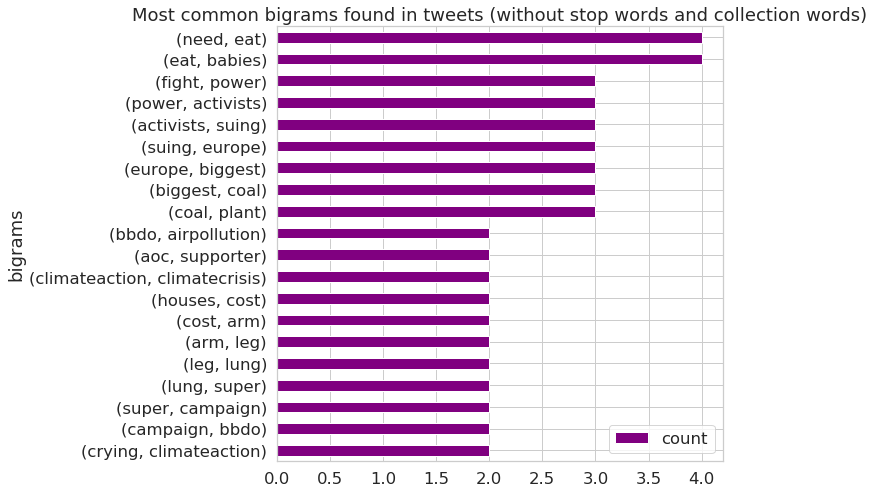

In [64]:
# Flatten list of bigrams
bigrams = list(itertools.chain(*tweet_bigrams))

# Create a counter of most frequent bigrams
bigrams_count = collections.Counter(bigrams)
bigram_df = pd.DataFrame(bigrams_count.most_common(20),
                         columns=['bigrams', 'count'])

# Plot horizontal bar graph
fig, ax = plt.subplots(figsize=(8, 8))
bigram_df.sort_values(by='count').plot.barh(x='bigrams',
                                                  y='count',
                                                  ax=ax,
                                                  color='purple')
ax.set_title("Most common bigrams found in tweets (without stop words and collection words)")
plt.show()

### Geospatial analysis
Next we will look at where are people tweeting from.

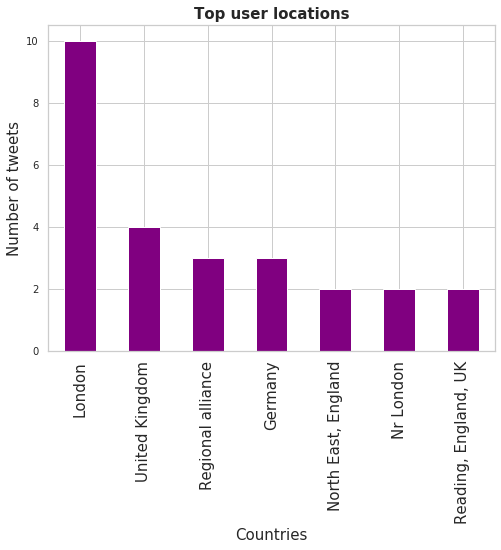

In [65]:
# Plot horizontal bar graph to see where majority of tweets are from
tweets_by_country = tweets_df['user_location'].value_counts()

fig, ax = plt.subplots(figsize=(8,6))
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Countries', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top user locations',fontsize=15, fontweight='bold')
tweets_by_country[1:8].plot(ax=ax, kind='bar', color='purple')

To get better sense of where the majority of tweets are coming from we will use the user locations in text format such as "London, England" and transform it into latitude and longitude coordinates. Having the coordinates we can create a heatmap visualization.

In [26]:
# Plot user locations on heatmap
geoloc = Nominatim()


# Go through all tweets and add locations to 'coordinates' dictionary
coordinates = {'latitude': [], 'longitude': []}  

for count, user_loc in enumerate(tweets_df.user_location):  
    try:
        location = geoloc.geocode(user_loc)
        

        # If coordinates are found for location append them and wait so the TimeOut Error is not raised
        if location:
            coordinates['latitude'].append(location.latitude)
            coordinates['longitude'].append(location.longitude)
            time.sleep(0.5)

    # If too many connection requests
    except:
        pass

# Instantiate and center a GoogleMapPlotter object to show our map
gmap = gmplot.GoogleMapPlotter(30, 0, 3)

# Insert points on the map passing a list of latitudes and longitudes
gmap.heatmap(coordinates['latitude'], coordinates['longitude'], radius=20)

# Save the map to html file
gmap.draw("vis/tweets_heatmap.html")

### Sentiment analysis
Sentiment analysis or otherwise known as opinion mining, looks at the emotional tone behind a series of words, used to gain an understanding of the the attitudes, opinions and emotions expressed within a text. Sentiment analysis is extremely useful in social media monitoring as it allows us to gain an overview of the wider public opinion behind the analysed topic. 

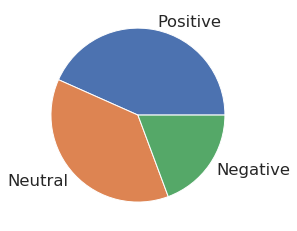

In [66]:
# Plot pie chart of sentiment classes
tweets_sentiment = tweets_df['sentiment_class'].value_counts()

# Create a pie chart
plt.pie(tweets_sentiment, labels=tweets_sentiment.index)
plt.show()

In [67]:
# Print descriptive statistics
tweets_df.sentiment.describe()

count    150.000000
mean     0.113959  
std      0.293348  
min     -0.714286  
25%      0.000000  
50%      0.000000  
75%      0.325000  
max      1.000000  
Name: sentiment, dtype: float64

In [68]:
# Show the most positive tweet
tweets_df.text.loc[tweets_df['sentiment'].idxmax()]

'Thank you Mr President The youths of this country are very happy under your leadership Majority of them are empl'

In [69]:
# Show the most positive tweet
tweets_df.text.loc[tweets_df['sentiment'].idxmin()]

'Bernie sanders suggested going overseas to do abortions for climate How sick is this'